In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


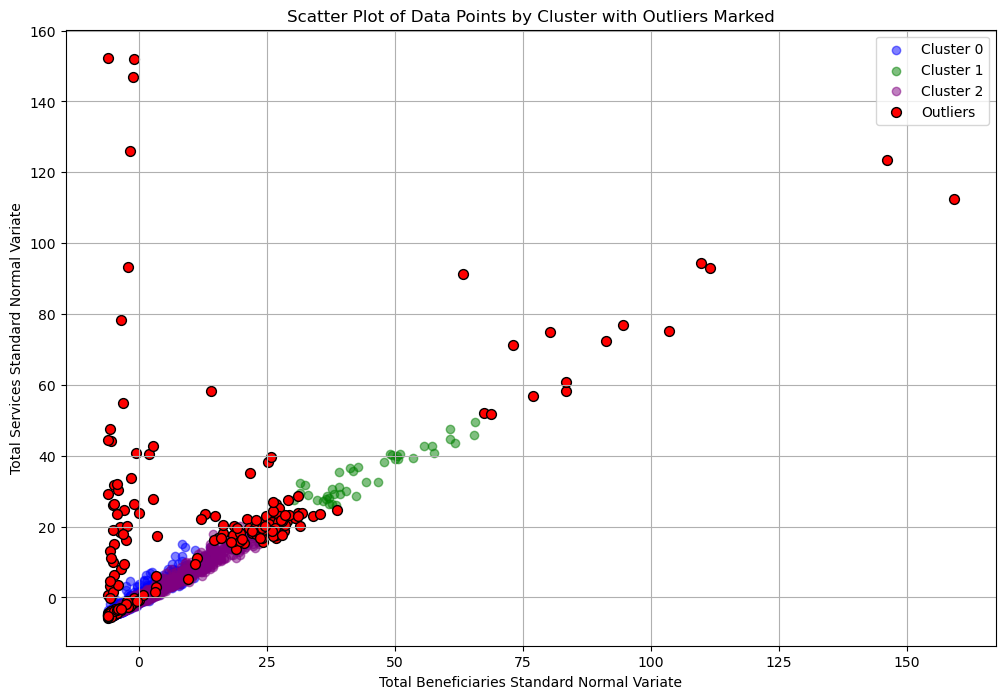

   Tot_Benes  Tot_Srvcs  Avg_Mdcr_Stdzd_Amt  \
0         28       32.0              581.89   
1         29       38.0              771.93   
2         11       12.0              562.18   
3         13       22.0              117.75   
4         12       16.0              588.58   

   Tot_Benes_standard_normal_variate  Tot_Srvcs_standard_normal_variate  \
0                          -1.121410                          -2.113642   
1                          -0.838244                          -1.085041   
2                          -5.935226                          -5.542311   
3                          -5.368895                          -3.827976   
4                          -5.652060                          -4.856577   

   Avg_Mdcr_Stdzd_Amt_standard_normal_variate  Is_Outlier  Cluster  \
0                                   -1.245499       False        0   
1                                   12.295213       False        2   
2                                   -2.649874       Fals

In [6]:
data = pd.read_csv('original_data.csv')

# Define a function to calculate outliers based on the IQR
def calculate_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data[column] < lower_bound) | (data[column] > upper_bound)

X = data[['Tot_Benes_standard_normal_variate', 'Tot_Srvcs_standard_normal_variate', 'Avg_Mdcr_Stdzd_Amt_standard_normal_variate']]

kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

# Calculate distances from each point to its cluster center
distances = np.sqrt(((X - centroids[labels]) ** 2).sum(axis=1))
threshold = np.percentile(distances, 95)
data['Is_Outlier'] = distances > threshold
data['Cluster'] = labels  # Add cluster labels to the dataframe

# Apply IQR method to each column
data['IQR_Outlier_Tot_Benes'] = calculate_outliers_iqr(data, 'Tot_Benes_standard_normal_variate')
data['IQR_Outlier_Tot_Srvcs'] = calculate_outliers_iqr(data, 'Tot_Srvcs_standard_normal_variate')
data['IQR_Outlier_Avg_Mdcr_Amt'] = calculate_outliers_iqr(data, 'Avg_Mdcr_Stdzd_Amt_standard_normal_variate')

# Combine the three IQR outlier columns into a single 'Actual_Outliers' column
data['Actual_Outliers'] = data[['IQR_Outlier_Tot_Benes', 'IQR_Outlier_Tot_Srvcs', 'IQR_Outlier_Avg_Mdcr_Amt']].any(axis=1)

def introduce_structural_break(data, columns, break_point, new_mean_multiplier=10, new_std_multiplier=10, fraction=0.1):
    poisoned_data = data.copy()
    for col in columns:
        mean_val = poisoned_data[col].mean()
        std_val = poisoned_data[col].std()
        poisoned_data.loc[break_point:, col] = (poisoned_data.loc[break_point:, col] - mean_val) * new_std_multiplier + (mean_val * new_mean_multiplier)
    return poisoned_data

columns_to_convert = ['Tot_Benes_standard_normal_variate', 'Tot_Srvcs_standard_normal_variate', 'Avg_Mdcr_Stdzd_Amt_standard_normal_variate']
break_point = 0
structural_break_data = introduce_structural_break(data, columns_to_convert, break_point)

plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'purple']

for cluster in range(3):
    cluster_data = structural_break_data[structural_break_data['Cluster'] == cluster]
    plt.scatter(cluster_data['Tot_Benes_standard_normal_variate'], cluster_data['Tot_Srvcs_standard_normal_variate'], color=colors[cluster], label=f'Cluster {cluster}', alpha=0.5)

outliers = structural_break_data[structural_break_data['Is_Outlier']]
plt.scatter(outliers['Tot_Benes_standard_normal_variate'], outliers['Tot_Srvcs_standard_normal_variate'], color='red', label='Outliers', edgecolor='k', s=50)

plt.title('Scatter Plot of Data Points by Cluster with Outliers Marked')
plt.xlabel('Total Beneficiaries Standard Normal Variate')
plt.ylabel('Total Services Standard Normal Variate')
plt.legend()
plt.grid(True)
plt.show()

print(structural_break_data.head())
structural_break_data.to_csv('structure_data_outliers_0.05_mean_10_std_10.csv', index=False)

Confusion Matrix:
[[3482    0]
 [ 295  199]]


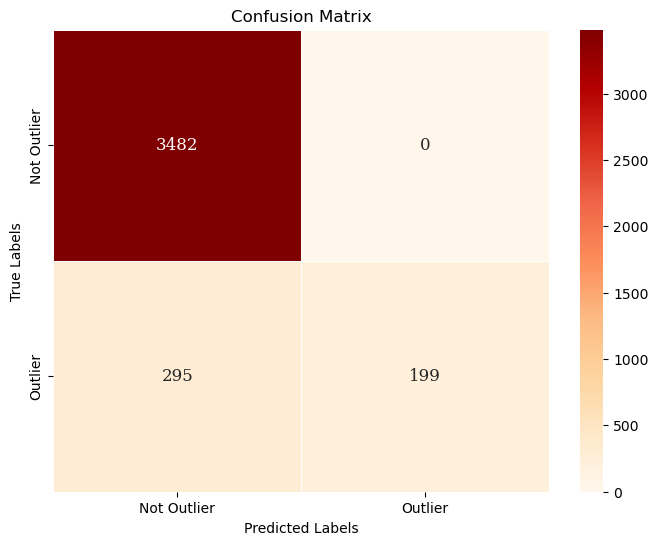

In [7]:
data = pd.read_csv('structure_data_outliers_0.05_mean_20_std_20.csv')

# Extract actual and predicted labels
actual_labels = data['Actual_Outliers']
predicted_labels = data['Is_Outlier']

# Calculate the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
.heatmapsns(cm, annot=True, fmt="d", cmap="OrRd", xticklabels=['Not Outlier', 'Outlier'], yticklabels=['Not Outlier', 'Outlier'],linewidths=.5, annot_kws={"fontsize": 12, "fontname": 'DejaVu Serif'})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [8]:
# Define the condition for each classification
conditions = [
    (actual_labels == False) & (predicted_labels == False),  # True Negative
    (actual_labels == False) & (predicted_labels == True),   # False Positive
    (actual_labels == True) & (predicted_labels == False),   # False Negative
    (actual_labels == True) & (predicted_labels == True)     # True Positive
]

# Define the label for each condition
labels = ['TN', 'FP', 'FN', 'TP']

# Create a new column in the dataframe that describes the classification of each data point
data['Classification'] = pd.Series(np.select(conditions, labels, default='Error'))

# Count the occurrences of each classification
classification_counts = data['Classification'].value_counts()

# Create a DataFrame for the counts
counts_df = pd.DataFrame(classification_counts).reset_index()
counts_df.columns = ['Classification', 'Count']

# Optionally print out the counts
print(counts_df)

# Save the modified data with the new classification to CSV
data.to_csv('modified_noise_data_with_classifications.csv', index=False)

# Save the counts to the same or a different CSV file
counts_df.to_csv('classification_counts.csv', index=False)

# Optionally, print out a few rows to see the classifications
print(data[['Actual_Outliers', 'Is_Outlier', 'Classification']].head())

  Classification  Count
0             TN   3482
1             FN    295
2             TP    199
   Actual_Outliers  Is_Outlier Classification
0            False       False             TN
1            False       False             TN
2            False       False             TN
3             True        True             TP
4            False       False             TN
